# Cross validation

## I) Imports

In [54]:
from proj1_helpers import *
from custom_helpers import *
from implementations import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II) Required functions

In [51]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [52]:
def cross_validation(x, y, flag_method, degree, lambda_=0, k_fold=5, gamma=1.e-6, max_iters=1000, seed=143225):
    "Train the model and evaluate loss based on cross validation"
    mses_tr = []
    mses_te = []
    
    k_indices = build_k_indices(y, k_fold, seed);
    for i in range(k_fold):
        newk_index = np.delete(k_indices, i, 0)
        indices_train = newk_index.ravel()
        indices_test = k_indices[i]

        # Train data at each iteration "i" of the loop
        x_train = x[indices_train]
        y_train = y[indices_train]

        # Validate the data at each iteration "i" of the loop
        x_test = x[indices_test]
        y_test = y[indices_test]

        # Prepare data (Standardisation and offset)
        training_tx, testing_tx = prepare_data(x_train, x_test, True, True, True, degree)
        
        # create initial w for methods using it
        initial_w = np.zeros(training_tx.shape[1])

        if flag_method == 0:
            # Use linear regression (full gradient descent)
            weight, loss_tr = least_squares_GD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 1:
            # Use linear regression (stochastic gradient descent)
            weight, loss_tr = least_squares_SGD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 2:
            # Use least squares method
            weight, loss_tr = least_squares(y_train, training_tx)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 3:
            # Use ridge regression
            weight, loss_tr = ridge_regression(y_train, training_tx, lambda_)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 4:
            # Use logistic regression
            y_train[np.where(y_train == -1)] = 0
            y_test[np.where(y_test == -1)] = 0
            weight, loss_tr = logistic_regression(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = calculate_log_loss(y_test, testing_tx, weight)
            
        if flag_method == 5:
            # Use regularized logistic regression
            y_train[np.where(y_train == -1)] = 0
            y_test[np.where(y_test == -1)] = 0
            weight, loss_tr = reg_logistic_regression(y_train, training_tx, initial_w, max_iters, gamma, lambda_)
            loss_te = calculate_log_loss(y_test, testing_tx, weight)
        
        # Append loss of this round to list
        mses_tr.append(loss_tr)
        mses_te.append(loss_te)


    loss_tr = np.mean(mses_tr)
    loss_te = np.mean(mses_te)
    return loss_tr, loss_te

## III) Main
### Load the data

In [42]:
# Loading Data
print("Loading Data, please wait")
train_y, train_x, ids_train = load_csv_data('data/train.csv')
print("Data loaded, continue!!")

Loading Data, please wait
Data loaded, continue!!


In [43]:
"""
Methods mapping
0    Linear regression (full gradient descent)
1    Linear regression (stochastic gradient descent)
2    Least squares method
3    Ridge regression
4    Logistic regression (stochastic gradient descent)
5    Regularized logistic regression (stochastic gradient descent)

"""

'\nMethods mapping\n0    Linear regression (full gradient descent)\n1    Linear regression (stochastic gradient descent)\n2    Least squares method\n3    Ridge regression\n4    Logistic regression (stochastic gradient descent)\n5    Regularized logistic regression (stochastic gradient descent)\n\n'

### Cross validation for methods without regularisation
Test polynominal expansion of different degrees

In [18]:
# Chose learnig method to use (see mapping above)
flag_method = 5;

# Define range for the polynomial expansion
degree_range = np.arange(1, 7)
train_losses = np.zeros(len(degree_range))
test_losses = np.zeros(len(degree_range))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree)
    print("For the Degree: %d , The LOSS is : %f" %(degree, loss_te))
    train_losses[ind_degree] = loss_tr
    test_losses[ind_degree] = loss_te
print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print("The best degrees are: ", degree_range[best_value])

iteration	 0 	loss:  0.0140847374300658
iteration	 100 	loss:  0.684736387915446
iteration	 200 	loss:  0.5545227714019784


KeyboardInterrupt: 

### Cross validation for Methods using regularisation
Grid search over different degrees of polynominal expansion and for different lambdas

In [17]:
# Chose learnig method to use (see mapping above)
flag_method = 3;

# Define range for the polynomial expansion and for lambda
degree_range = np.arange(1, 4)
lambda_range = np.arange(-0.01, 0.1, 0.01)
train_losses = np.zeros((len(degree_range), len(lambda_range)))
test_losses = np.zeros((len(degree_range), len(lambda_range)))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain = remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_)
        print("For the Degree: %d and lambda %f, The LOSS is : %f" %(degree, lambda_, loss_te))
        train_losses[ind_degree, ind_lambda_] = loss_tr
        test_losses[ind_degree, ind_lambda_] = loss_te

print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print(best_value)
print("Best degree: %d, with lambda %f " %(degree_range[best_value[0]], lambda_range[best_value[1]]))

For the Degree: 1 and lambda -0.010000, The LOSS is : 1.628009


KeyboardInterrupt: 

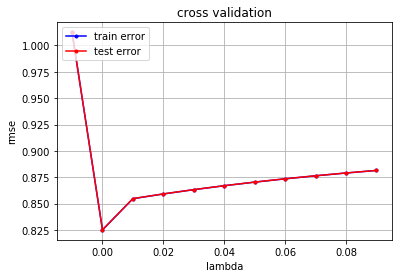

In [8]:
# Visualize
cross_validation_visualization(lambda_range, train_losses[0, :], test_losses[0, :])

In [15]:
"""
TODO: Implement plots for grid search (lambdas & poly degrees)





"""

'\nTODO: Implement plots for grid search (lambdas & poly degrees)\n\n\n\n\n\n'

In [56]:
# This is for Regularized logistic regression 
# Chose learnig method to use (see mapping above)
# cross_validation(x, y, flag_method, degree, lambda_=0, k_fold=5, gamma=1.e-6, max_iters=1000, seed=143225):
flag_method = 5;


# Define range for the polynomial expansion and for lambda
degree_range = np.arange(1, 4)
lambda_range = np.arange(-0.001, 0.1, 0.01)
gamma_range = np.arange(0.05, 1.0, 0.05)
train_losses = np.zeros((len(degree_range), len(lambda_range),len(gamma_range)))
test_losses = np.zeros((len(degree_range), len(lambda_range),len(gamma_range)))
k_fold=5
max_iters=100

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
ytrain_cross_validation[np.where(ytrain_cross_validation==-1)] = 0
xtrain=remove_invalid(xtrain)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        for ind_gamma_, gamma_ in enumerate(gamma_range):
            loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_,k_fold,gamma_,max_iters)
            print("For the Degree: %d the lambda: %f and the gamma: %f, The LOSS is : %f" %(degree, lambda_, gamma_, loss_te))
            train_losses[ind_degree, ind_lambda_,ind_gamma_] = loss_tr
            test_losses[ind_degree, ind_lambda_,ind_gamma_] = loss_te

print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print(best_value)
print("Best degree: %d, with lambda %f and gamma %f " %(degree_range[best_value[0]], lambda_range[best_value[1]],gamma_range[best_value[2]]))


iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277976275595147
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277974971001049
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277596124975752
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.627488801987339
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6278985371273635
For the Degree: 1 the lambda: -0.001000 and the gamma: 0.050000, The LOSS is : 0.599720
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164246781197379
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164123602523555
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164218115524244
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6160524110849134
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6165587898161068
For the Degree: 1 the lambda: -0.001000 and the gamma: 0.100000, The LOSS is : 0.57

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.7863479878196211
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.7903671511411263
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.795166235006819
For the Degree: 1 the lambda: -0.001000 and the gamma: 0.850000, The LOSS is : 1.262324
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.8656629184725873
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.8519476334815506
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.9524092754370104
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.8511228495361158
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.9415512934610524
For the Degree: 1 the lambda: -0.001000 and the gamma: 0.900000, The LOSS is : 2.122158
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.0799024191813134
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.020240852016

iteration	 50 	loss:  1.3424338402584157
For the Degree: 1 the lambda: 0.009000 and the gamma: 0.700000, The LOSS is : 1.599067
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5187498803423538
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4607461032706528
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.495865941412861
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5143328894055168
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.519144230636052
For the Degree: 1 the lambda: 0.009000 and the gamma: 0.750000, The LOSS is : 1.358919
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5683397613268975
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5822874394593254
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.6430184725709822
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5433385405333362
iteration	 0 	loss:  0.01386294361119890

iteration	 50 	loss:  1.0976880149834327
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1042110144874726
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.145653782498068
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0889669745025474
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1228240703764458
For the Degree: 1 the lambda: 0.019000 and the gamma: 0.600000, The LOSS is : 0.956870
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1753992805065587
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.270598696416537
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.205099614866798
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1215832706179227
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.205403001198232
For the Degree: 1 the lambda: 0.019000 and the gamma: 0.650000, The LOSS is : 1.187390
iteration	 0 	loss:  0.013862943611198907


iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9257274857160895
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9283573021681135
For the Degree: 1 the lambda: 0.029000 and the gamma: 0.450000, The LOSS is : 0.722897
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.022548847712065
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.021872127853152
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0236507231284866
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0206286827684956
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.023596347004329
For the Degree: 1 the lambda: 0.029000 and the gamma: 0.500000, The LOSS is : 0.785787
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.088885129717656
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0880785994592415
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0900972973834915


iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6876239367604831
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6872562316204837
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6878690621498119
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6862785851172362
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6882055078719652
For the Degree: 1 the lambda: 0.039000 and the gamma: 0.350000, The LOSS is : 0.558876
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8137480205753661
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8133123252063758
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8140960023696527
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8121484980241783
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8144442158446832
For the Degree: 1 the lambda: 0.039000 and the gamma: 0.400000, The LOSS is : 0.648

iteration	 50 	loss:  0.6025423919014529
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6019377448770846
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6026086829371217
For the Degree: 1 the lambda: 0.049000 and the gamma: 0.200000, The LOSS is : 0.554021
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.5973075134321957
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.5972222874250667
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.597548522481463
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.596834115800797
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.5975783522142577
For the Degree: 1 the lambda: 0.049000 and the gamma: 0.250000, The LOSS is : 0.545546
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.5961595760985461
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.5960315830689438
iteration	 0 	loss:  0.01386294361119890

For the Degree: 1 the lambda: 0.059000 and the gamma: 0.050000, The LOSS is : 0.599720
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164246995452891
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164123817847647
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.616421833194334
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6160524325799418
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6165588110530505
For the Degree: 1 the lambda: 0.059000 and the gamma: 0.100000, The LOSS is : 0.579833
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6086371544007259
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6085998265641833
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6087107691849244
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6082226525478253
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.60881480401165

iteration	 50 	loss:  1.8502360554624664
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.9506150713054882
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.8572279906130382
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.9401351671842264
For the Degree: 1 the lambda: 0.059000 and the gamma: 0.900000, The LOSS is : 1.424681
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.0772507485411746
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.0090522278308933
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.9816660570453422
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.0587169610178226
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.0058020576294937
For the Degree: 1 the lambda: 0.059000 and the gamma: 0.950000, The LOSS is : 1.287256
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277976419260615
iteration	 0 	loss:  0.013862943611198

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5192761421562302
For the Degree: 1 the lambda: 0.069000 and the gamma: 0.750000, The LOSS is : 0.997503
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5855872056808118
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5812396130785842
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.642841923571166
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.547822799459452
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.6370292777434852
For the Degree: 1 the lambda: 0.069000 and the gamma: 0.800000, The LOSS is : 1.083019
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.6858939751861994
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.7132081959665202
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.7681914788112163
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.780866826671749

iteration	 50 	loss:  1.1227731789289737
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.2688199258511879
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.2120483556056687
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1510685265935507
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.2054925644264403
For the Degree: 1 the lambda: 0.079000 and the gamma: 0.650000, The LOSS is : 1.154997
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.3376325087833123
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.2862576143230111
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.3477941181433022
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.3295493970506314
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.3499639839586288
For the Degree: 1 the lambda: 0.079000 and the gamma: 0.700000, The LOSS is : 1.360431
iteration	 0 	loss:  0.013862943611198

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0206289733524532
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0235966347517758
For the Degree: 1 the lambda: 0.089000 and the gamma: 0.500000, The LOSS is : 0.785787
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0888853529388627
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0880788254633071
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0900975106081805
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0877266178359644
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.089930083641255
For the Degree: 1 the lambda: 0.089000 and the gamma: 0.550000, The LOSS is : 0.841103
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.096687022012159
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1031356750699277
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.145621870102706

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8137483037566633
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8133126083083232
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8140962920912981
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8121487811204939
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8144444965711787
For the Degree: 1 the lambda: 0.099000 and the gamma: 0.400000, The LOSS is : 0.648365
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9275283311916759
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9270123838452463
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9280708282121211
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9257278725857729
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9283576858484668
For the Degree: 1 the lambda: 0.099000 and the gamma: 0.450000, The LOSS is : 0.722

iteration	 50 	loss:  1.0382562646845275
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0363119760125343
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0384776496490635
For the Degree: 2 the lambda: -0.001000 and the gamma: 0.250000, The LOSS is : 0.848174
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1729424266401904
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1739367684039752
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1550632968132095
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1646646634335083
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1461660782341885
For the Degree: 2 the lambda: -0.001000 and the gamma: 0.300000, The LOSS is : 1.648261
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4065634550790274
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.3635537117134364
iteration	 0 	loss:  0.0138629436111

For the Degree: 2 the lambda: 0.009000 and the gamma: 0.100000, The LOSS is : 0.615477
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6276671373652711
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277514183054392
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6276153174849811
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6273636469245415
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277119467636383
For the Degree: 2 the lambda: 0.009000 and the gamma: 0.150000, The LOSS is : 0.609127
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8236691057936539
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.823521740119316
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8239342937278872
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8226638095308642
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.82425968651422

iteration	 50 	loss:  4.943291028906169
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.93442571184356
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.932057824575981
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.939706244245936
For the Degree: 2 the lambda: 0.009000 and the gamma: 0.950000, The LOSS is : 2.258932
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6315372092429908
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.631638531986948
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6314565610746311
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6312700272786624
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6315535138333548
For the Degree: 2 the lambda: 0.019000 and the gamma: 0.050000, The LOSS is : 0.622708
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6280034477770964
iteration	 0 	loss:  0.013862943611198907
it

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.140237494558858
For the Degree: 2 the lambda: 0.019000 and the gamma: 0.800000, The LOSS is : 1.824772
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.406573380697796
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.410656259661746
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.402681194401523
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.4007973058224055
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.407381505716299
For the Degree: 2 the lambda: 0.019000 and the gamma: 0.850000, The LOSS is : 1.969804
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.672915563770901
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.677243903403761
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.6688092411871525
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.666686389410977
iter

iteration	 50 	loss:  3.6011483891294636
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.604566140485464
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.597880820470815
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.596667916731067
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.6016928104500128
For the Degree: 2 the lambda: 0.029000 and the gamma: 0.700000, The LOSS is : 1.533640
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8713035488122474
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8749146277865223
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8678537635320884
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8664061740589815
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.871950143672712
For the Degree: 2 the lambda: 0.029000 and the gamma: 0.750000, The LOSS is : 1.679395
iteration	 0 	loss:  0.013862943611198907


iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.757507097312559
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.7605708735680694
For the Degree: 2 the lambda: 0.039000 and the gamma: 0.550000, The LOSS is : 1.091099
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.048778243138332
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.051951172273333
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.045702430273479
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.0451935256491107
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.049005005962955
For the Degree: 2 the lambda: 0.039000 and the gamma: 0.600000, The LOSS is : 1.240330
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.3276898438318288
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.330957997916513
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.3245521017664283
it

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.0676247294167327
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.1023284686906276
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.021954220374372
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.94685914207185
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.027749810999314
For the Degree: 2 the lambda: 0.049000 and the gamma: 0.450000, The LOSS is : 2.404529
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.4543644790618275
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.4577678221252794
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.450842033975078
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.4518753414585976
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.453919158078952
For the Degree: 2 the lambda: 0.049000 and the gamma: 0.500000, The LOSS is : 0.936091
it

iteration	 50 	loss:  1.1550226583391503
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1647968328929508
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1464083639914193
For the Degree: 2 the lambda: 0.059000 and the gamma: 0.300000, The LOSS is : 1.821841
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4032047626438027
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.327144719133845
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4118803080130042
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4244059914830618
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.3907100625335531
For the Degree: 2 the lambda: 0.059000 and the gamma: 0.350000, The LOSS is : 0.703199
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.6756389289175655
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.690062109086187
iteration	 0 	loss:  0.01386294361119890

For the Degree: 2 the lambda: 0.069000 and the gamma: 0.150000, The LOSS is : 0.609127
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8236692048874156
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8235218378614293
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8239343957480759
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8226639090809407
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.8242597865585224
For the Degree: 2 the lambda: 0.069000 and the gamma: 0.200000, The LOSS is : 0.749816
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.037657711683356
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0372444405547874
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.038256378027108
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.0363120836836806
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.038477758932036

iteration	 50 	loss:  0.6316385386746933
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.631456567894213
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6312700340356173
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6315535205647085
For the Degree: 2 the lambda: 0.079000 and the gamma: 0.050000, The LOSS is : 0.622708
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6280034583747438
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6281071345899707
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6279163192703736
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.627714338880341
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6280178236355433
For the Degree: 2 the lambda: 0.079000 and the gamma: 0.100000, The LOSS is : 0.615477
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.627667154982064
iteration	 0 	loss:  0.013862943611198907

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.407389472136086
For the Degree: 2 the lambda: 0.079000 and the gamma: 0.850000, The LOSS is : 1.969813
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.672924514751332
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.67725282343768
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.6688183228785025
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.666695403273456
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.673816528124355
For the Degree: 2 the lambda: 0.079000 and the gamma: 0.900000, The LOSS is : 2.114524
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.938737055406216
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.943302678982185
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.934437569393483
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.932069595612434
iterat

iteration	 50 	loss:  3.8713096159129274
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8749206716873927
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8678599185272655
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8664122832181023
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.8719562360077084
For the Degree: 2 the lambda: 0.089000 and the gamma: 0.750000, The LOSS is : 1.679402
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.139516455989573
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.143354799641072
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.135850181381052
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.134189168625068
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.140245656984329
For the Degree: 2 the lambda: 0.089000 and the gamma: 0.800000, The LOSS is : 1.824781
iteration	 0 	loss:  0.013862943611198907
i

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.045197359592507
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.0490088316933774
For the Degree: 2 the lambda: 0.099000 and the gamma: 0.600000, The LOSS is : 1.240334
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.327694328194034
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.3309624619813247
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.324556653004953
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.323643965036449
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.3281018206931936
For the Degree: 2 the lambda: 0.099000 and the gamma: 0.650000, The LOSS is : 1.387412
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.6011545011201536
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.6045722273050944
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.597887021776927
i

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.9936004309058664
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.9965874506632377
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.997246581123647
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.990249844592861
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.997003039298244
For the Degree: 3 the lambda: -0.001000 and the gamma: 0.500000, The LOSS is : 2.071693
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.40601601834529
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.4093211642792856
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.410191206367237
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.40221258290794
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.40990122166712
For the Degree: 3 the lambda: -0.001000 and the gamma: 0.550000, The LOSS is : 2.355770
iter

iteration	 50 	loss:  2.710268116704577
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.706418462026786
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.709988295033399
For the Degree: 3 the lambda: 0.009000 and the gamma: 0.350000, The LOSS is : 1.238680
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.1515006622947026
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.153928564044622
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.154185203631592
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.1492348119181606
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.153956847917484
For the Degree: 3 the lambda: 0.009000 and the gamma: 0.400000, The LOSS is : 1.511560
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.576821246977864
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.5795102169819155
iteration	 0 	loss:  0.013862943611198907
ite

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4806323023414292
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4742422804382784
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5141174315699772
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5509615795516607
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5122651385318957
For the Degree: 3 the lambda: 0.019000 and the gamma: 0.250000, The LOSS is : 0.881683
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.213409499157606
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.216251150958301
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.215110608858724
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.212752844024695
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.214695202202662
For the Degree: 3 the lambda: 0.019000 and the gamma: 0.300000, The LOSS is : 0.957909
i

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6353261692421435
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6355814278843603
For the Degree: 3 the lambda: 0.029000 and the gamma: 0.100000, The LOSS is : 0.630935
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9222217927709737
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9219564513229456
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9233828084000558
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9213735679772127
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9233455379316127
For the Degree: 3 the lambda: 0.029000 and the gamma: 0.150000, The LOSS is : 0.820978
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.143083914246872
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1108167215945195
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.11660369151237

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.665219134300872
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.671335819462086
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.673781882474402
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.65813608036704
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.672918689944419
For the Degree: 3 the lambda: 0.029000 and the gamma: 0.950000, The LOSS is : 4.635644
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6351122358685048
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6352301900952875
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6350705089881395
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6348498605638458
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6350918999601892
For the Degree: 3 the lambda: 0.039000 and the gamma: 0.050000, The LOSS is : 0.632518
it

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.440604299569061
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.4527689339528775
For the Degree: 3 the lambda: 0.039000 and the gamma: 0.800000, The LOSS is : 3.781646
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.852945970368771
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.858344751442495
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.860422814549354
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.846665347778127
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.859708037240609
For the Degree: 3 the lambda: 0.039000 and the gamma: 0.850000, The LOSS is : 4.066525
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.259174724651758
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.2649321523266535
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.267196661425046
iter

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.632508020847244
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.636838884770314
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.638330325877996
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.6274472689437
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.637839963010748
For the Degree: 3 the lambda: 0.049000 and the gamma: 0.700000, The LOSS is : 3.211340
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.039705096805216
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.044389836303493
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.046081070981311
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.034235223852389
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  6.045516410268944
For the Degree: 3 the lambda: 0.049000 and the gamma: 0.750000, The LOSS is : 3.496573
iteratio

iteration	 50 	loss:  4.410194014386764
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.402215385268334
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.409904003520705
For the Degree: 3 the lambda: 0.059000 and the gamma: 0.550000, The LOSS is : 2.355772
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.816062592238593
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.8197004972614295
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.820781069613693
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.811831230474623
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  4.820430921970525
For the Degree: 3 the lambda: 0.059000 and the gamma: 0.600000, The LOSS is : 2.640734
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.224721980833218
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  5.228703023701672
iteration	 0 	loss:  0.013862943611198907
itera

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.5768230191930535
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.5795119746437303
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.579966778479108
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.573975286504857
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.579747288115217
For the Degree: 3 the lambda: 0.069000 and the gamma: 0.450000, The LOSS is : 1.789644
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.993603041791211
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.9965900414346076
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.997249242069718
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.9902524991103054
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.997005675433531
For the Degree: 3 the lambda: 0.069000 and the gamma: 0.500000, The LOSS is : 2.071694
it

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.2127536974549558
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.214696058279396
For the Degree: 3 the lambda: 0.079000 and the gamma: 0.300000, The LOSS is : 0.957910
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.708002439085379
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.7102844472549696
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.7102693381923033
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.706419676112103
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  2.709989505322727
For the Degree: 3 the lambda: 0.079000 and the gamma: 0.350000, The LOSS is : 1.238681
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.151502252661121
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.1539301404294675
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  3.154186826100276
it

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1435229026719114
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1107166719988257
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1166179995183876
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.094942521038045
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.1142442248758384
For the Degree: 3 the lambda: 0.089000 and the gamma: 0.200000, The LOSS is : 1.407645
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.4686887930061818
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.441607436760821
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.5205996852917196
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.550752219680367
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  1.513788480258012
For the Degree: 3 the lambda: 0.089000 and the gamma: 0.250000, The LOSS is : 0.734979


iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.634849864009594
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6350919034089951
For the Degree: 3 the lambda: 0.099000 and the gamma: 0.050000, The LOSS is : 0.632518
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.635596627989672
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6357052501108086
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6355568571866514
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6353261754323783
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6355814340684891
For the Degree: 3 the lambda: 0.099000 and the gamma: 0.100000, The LOSS is : 0.630935
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9222218471188098
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.9219565044363799
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.923382864746863

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.259182514101833
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.2649398974488895
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.267204585542961
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.252499947312502
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.266415153611247
For the Degree: 3 the lambda: 0.099000 and the gamma: 0.900000, The LOSS is : 4.351205
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.665229295296323
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.671345922740379
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.67379221632947
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.658146410673404
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  7.67292894010433
For the Degree: 3 the lambda: 0.099000 and the gamma: 0.950000, The LOSS is : 4.635660
Cross V

In [57]:
print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print(best_value)
print("Best degree: %d, with lambda %f and gamma %f " %(degree_range[best_value[0]], lambda_range[best_value[1]],gamma_range[best_value[2]]))


Cross Validation finished!!
(0, 0, 5)
Best degree: 1, with lambda -0.001000 and gamma 0.300000 


In [59]:
# This is for Regularized logistic regression 
# Chose learnig method to use (see mapping above)
# cross_validation(x, y, flag_method, degree, lambda_=0, k_fold=5, gamma=1.e-6, max_iters=1000, seed=143225):
flag_method = 5;


# Define range for the polynomial expansion and for lambda
degree_range = np.arange(1, 4)
lambda_range = np.arange(0.001, 0.1, 0.005)
gamma_range = np.arange(0.05, 1.0, 0.05)
train_losses = np.zeros((len(degree_range), len(lambda_range),len(gamma_range)))
test_losses = np.zeros((len(degree_range), len(lambda_range),len(gamma_range)))
k_fold=5
max_iters=100

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
ytrain_cross_validation[np.where(ytrain_cross_validation==-1)] = 0
xtrain=remove_invalid(xtrain)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        for ind_gamma_, gamma_ in enumerate(gamma_range):
            loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_,k_fold,gamma_,max_iters)
            print("For the Degree: %d the lambda: %f and the gamma: %f, The LOSS is : %f" %(degree, lambda_, gamma_, loss_te))
            train_losses[ind_degree, ind_lambda_,ind_gamma_] = loss_tr
            test_losses[ind_degree, ind_lambda_,ind_gamma_] = loss_te

print("Cross Validation finished!!")
test_losses_abs = np.absolute(test_losses)
best_value = np.unravel_index(np.argmin(test_losses_abs), test_losses.shape)
print(best_value)
print("Best degree: %d, with lambda %f and gamma %f " %(degree_range[best_value[0]], lambda_range[best_value[1]],gamma_range[best_value[2]]))


iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277976279699885
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277974975103736
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6277596129135861
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6274888023990611
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.62789853753578
For the Degree: 1 the lambda: 0.001000 and the gamma: 0.050000, The LOSS is : 0.599720
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164246788339244
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164123609701035
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6164218122738228
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6160524118014158
iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6165587905240063
For the Degree: 1 the lambda: 0.001000 and the gamma: 0.100000, The LOSS is : 0.57983

KeyboardInterrupt: 